In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from pylab import rcParams

In [611]:

class kostili:
    def __init__(self,data):
        self.data=data
    def load_data(self):
        
        columns=['id',
        'region',
        'objElemLivingCnt',
        'objElemParkingCnt',
        'objSquareLiving',
        'objLkClassDesc',
        'residentialBuildings',
        'objFloorCnt',
        'objFlatCnt',
        'objFlatSq',
        'objPriceAvg',
        'objReady100PercDt']

        df=self.data

        df['year']=pd.to_datetime(df['objReady100PercDt']).dt.year.astype('str')
        df['kv_metr']=df['objSquareLiving']/df['objFlatCnt']
        live_class = df[df['objLkClassDesc'] != 'Другое']['objLkClassDesc'].unique() 
        region = df['region'].unique()

        for cla in live_class:
            for reg in region:
                filter = (df['objLkClassDesc'] == cla) & (df['region'] == reg)
                df.loc[filter,'med_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].median())
                df.loc[filter,'avg_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].mean())
                
                
        order = ['Другое', 'Типовой', 'Комфорт', 'Бизнес', 'Элитный']
        df['code_type_obj'] = df['objLkClassDesc'].astype('category').cat.set_categories(order).cat.codes
                

        df.loc[df['med_price'].isnull(),'med_price'] = df.med_price.median()
        df.loc[df['avg_price'].isnull(),'avg_price'] = df.avg_price.median()

        df['med_price'] = df['med_price'].astype(int)
        df['avg_price'] = df['avg_price'].astype(int)

        top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']
        df=df[df['region'].isin(top_reg)].reset_index(drop=True)

        self.data = df

        return self.data
    def _check_cnt_obj_(self):
        df=self.data
        df_grouped=df.groupby(['region'])['id'].count().reset_index().set_index(['region'])
        df_grouped = df_grouped.rename(columns={'id': 'count_'})
        df_grouped[df_grouped.count_ > 100].sort_values('count_',ascending = False)\
        .plot(kind ='bar',
            stacked = True,
            figsize = (10,10),
            ylabel ='Количество объектов на регион из датасета',
            xlabel ='Регион',
            legend = False)
        plt.title('Колличество объектов по регионам')
    
    def flat_on_obj_class(self):
        ''' колличество квартир на объект в разрезе класса недвижимости по регионам '''
        df=self.data
        year_check=["2023","2024","2025","2026","2027","2028","2029"]
        sns.relplot(
            x='year',
            y='objFlatCnt',
            hue='objLkClassDesc',
            data=df[df['year'].isin(year_check)].groupby(['region','objLkClassDesc','year'])['objFlatCnt'].mean().reset_index(),
            row='region',
            kind='line',
            aspect=2,
            height=2)
    def analiz_parking(self):
        df=self.data
        
        '''График паркинга и количества квартир на объект на регион из датасета
        на второй группе графиков показаны квартиры и парковки в разрезе класса недвижимости по регионам'''

        year_check=["2023","2024","2025","2026","2027","2028","2029"]
        df_parking = df[df.year.isin(year_check)][['region','objLkClassDesc','year','objElemParkingCnt','objFlatCnt']]

        df_parking_long = pd.melt(df_parking,var_name='type',value_name='values',
                            id_vars=['region','objLkClassDesc','year'])
        
        grouped_df=df_parking_long.groupby(['region',
                                    'year','type'])['values'].mean().reset_index()
        sns.relplot(
        x='year',
        y='values',
        data=grouped_df,
        row='region',
        hue='type',
        kind='line',
        aspect=2,
        height=2)


        sns.relplot(
        x='year',
        y='values',
        hue='objLkClassDesc',
        data=df_parking_long.groupby(['region',
                                    'objLkClassDesc',
                                    'year','type'])['values'].mean().reset_index(),
        row='region',
        col='type',
        kind='line',
        aspect=2,
        height=3)

    def parking_on_reg(self):
        df=self.data

        df=self.data

        year_check=["2024","2025","2026","2027"]
        df_parking = df[df.year.isin(year_check)][['region','objLkClassDesc','year','objElemParkingCnt','objFlatCnt']]
        df_parking_long = pd.melt(df_parking,var_name='type',value_name='values',
                            id_vars=['region','objLkClassDesc','year'])

        year_check=["2023","2024","2025","2026","2027"]
        sns.catplot(
            x='year',
            y='values',
            order=year_check,
            hue='region',
            data=df_parking_long.query('type == "objElemParkingCnt" and values < 1100'),
            dodge=True,
            palette='viridis')
        plt.title('Диаграмма рассеяния с колличеством парковочных мест по регионам за период 2024-2027', size=10, color='y')
        plt.ylabel('Число парковочных мест', size=10, color='y')
        plt.minorticks_on()

    # def parking_on_reg_(self):
    #     df=self.data

    #     year_check=["2024","2025","2026","2027"]
    #     df_parking = df[df.year.isin(year_check)][['region','objLkClassDesc','year','objElemParkingCnt','objFlatCnt']]
    #     df_parking_long = pd.melt(df_parking,var_name='type',value_name='values',
    #                         id_vars=['region','objLkClassDesc','year'])
    #     sns.boxplot(
    #     x='year',
    #     y='values',
    #     hue='region',
    #     data=df_parking_long.query('type == "objElemParkingCnt" and year in("2024","2025","2026","2027") and values < 1100'),
    #     palette='viridis')
        # plt.title('Диаграмма рассеяния с колличеством парковочных мест по регионам за период 2024-2027', size=14, color='g')
        # plt.ylabel('Количество парковочных мест', size=10,color='g')
        # plt.minorticks_on()

    def price_on_reg(self):

        '''выводит среднуюю и медианную цену за квадратный метр по региону в разрезе класса жилья'''
        df=self.data
        df_prices = df[['region','objLkClassDesc','year','med_price','avg_price']]
        df_price_long = pd.melt(df_prices,var_name='type',value_name='price',
                            id_vars=['region','objLkClassDesc','year'])
        sns.relplot(
            x='year',
            y='price',
            hue='objLkClassDesc',
            data=df_price_long.groupby(['region','objLkClassDesc','year','type'])['price'].mean().reset_index(),
            row='region',
            kind='line',
            col='type',
            aspect=4,
            height=2)
        
        year_check=["2023","2024","2025","2026","2027"]
        sns.catplot(
            x='year',
            y='avg_price',
            col='objLkClassDesc',
            order=year_check,
            hue='region',
            data=df.query('objLkClassDesc != "Другое" and objLkClassDesc != "Элитный" and avg_price <=600000'),
            dodge=True,
            palette='deep')
        
        sns.catplot(
            x='year',
            y='avg_price',
            col='objLkClassDesc',
            order=year_check,
            hue='region',
            data=df.query('objLkClassDesc == "Элитный"'),
            dodge=True,
            palette='deep')
    
    def box_price(self):
        df=self.data
        year_check=["2023","2024","2025","2026","2027"]
        g = sns.catplot(
            data=df,
            x="avg_price", y="year", row="region",
            kind="box", orient="h",order=year_check,
            sharex=False, margin_titles=True,    
            height=1.5, aspect=6)
        g.set(xlabel="summa", ylabel="",title='Разброс цен по годам\регионам')
        g.set_titles(row_template="{row_name} region")
        for ax in g.axes.flat:
            ax.xaxis.set_major_formatter('{x:.0f}')

        g = sns.catplot(
            data=df.query('objLkClassDesc != "Другое"'),
            x="avg_price",
            y="year",
            row="objLkClassDesc",
            kind="box", 
            orient="h",
            order=year_check,
            sharex=False,
            margin_titles=True,    
            height=2, aspect=4 )
        
        g.set(xlabel="summa", ylabel="год",title='Разброс цен по годам\класс объекта')
        g.set_titles(row_template="{row_name} class")
        for ax in g.axes.flat:
            ax.xaxis.set_major_formatter('{x:.0f}')

    def heatmap_class(self):
        df=self.data
        df_cor=df[['region','objElemLivingCnt','objElemParkingCnt','objSquareLiving','residentialBuildings'
            ,'objFloorCnt','objFlatCnt','objFlatSq','avg_price','code_type_obj','year','kv_metr']]
        plt.figure(figsize=(9, 6))
        sns.heatmap(df_cor.corr(), annot=True, cmap='rocket')

    
    def run(self):
        self.load_data()
        self._check_cnt_obj_()
        self.flat_on_obj_class()
        # self.parking_on_reg_()
        self.analiz_parking()
        self.parking_on_reg()
        self.price_on_reg()
        self.box_price()
        self.heatmap_class()
       
    
    

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout ha

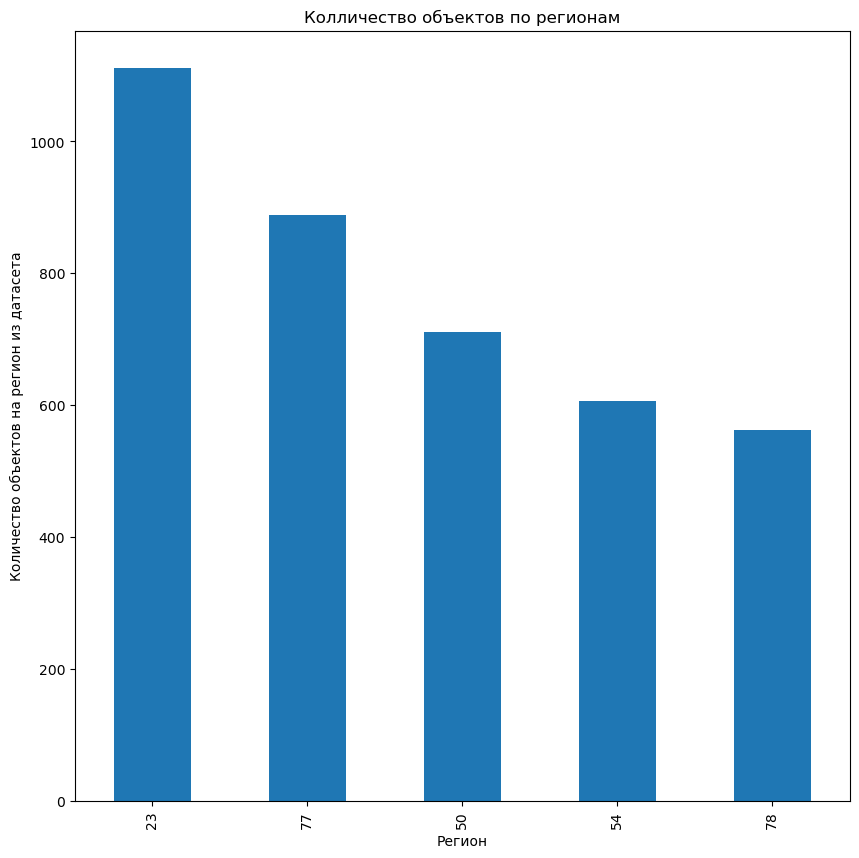

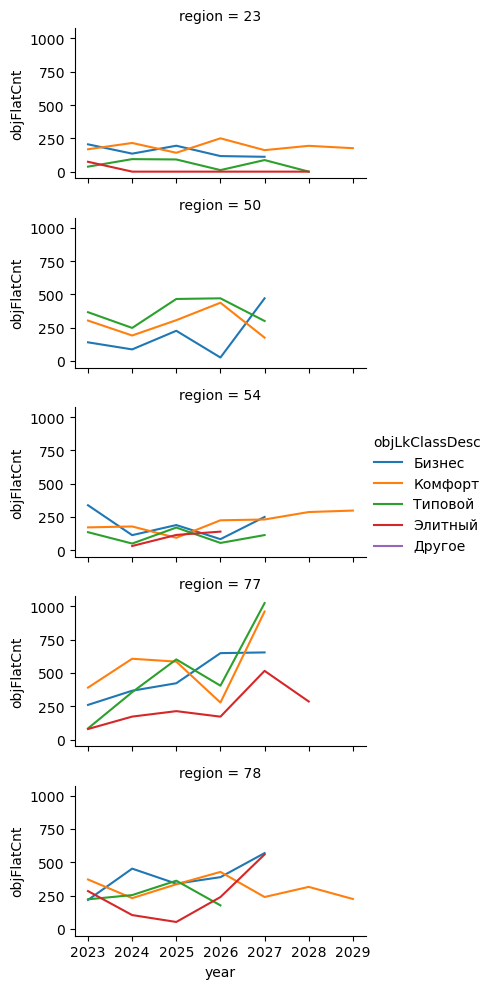

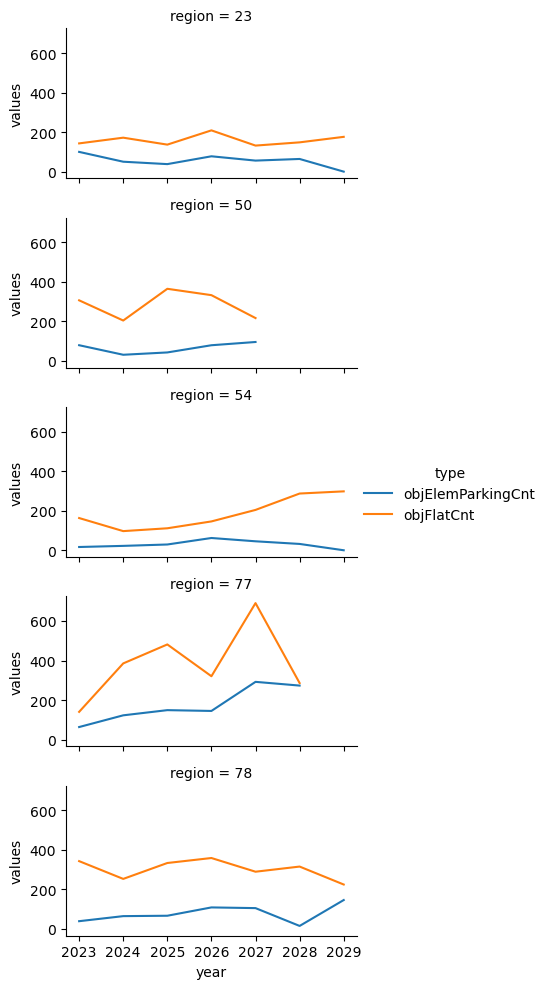

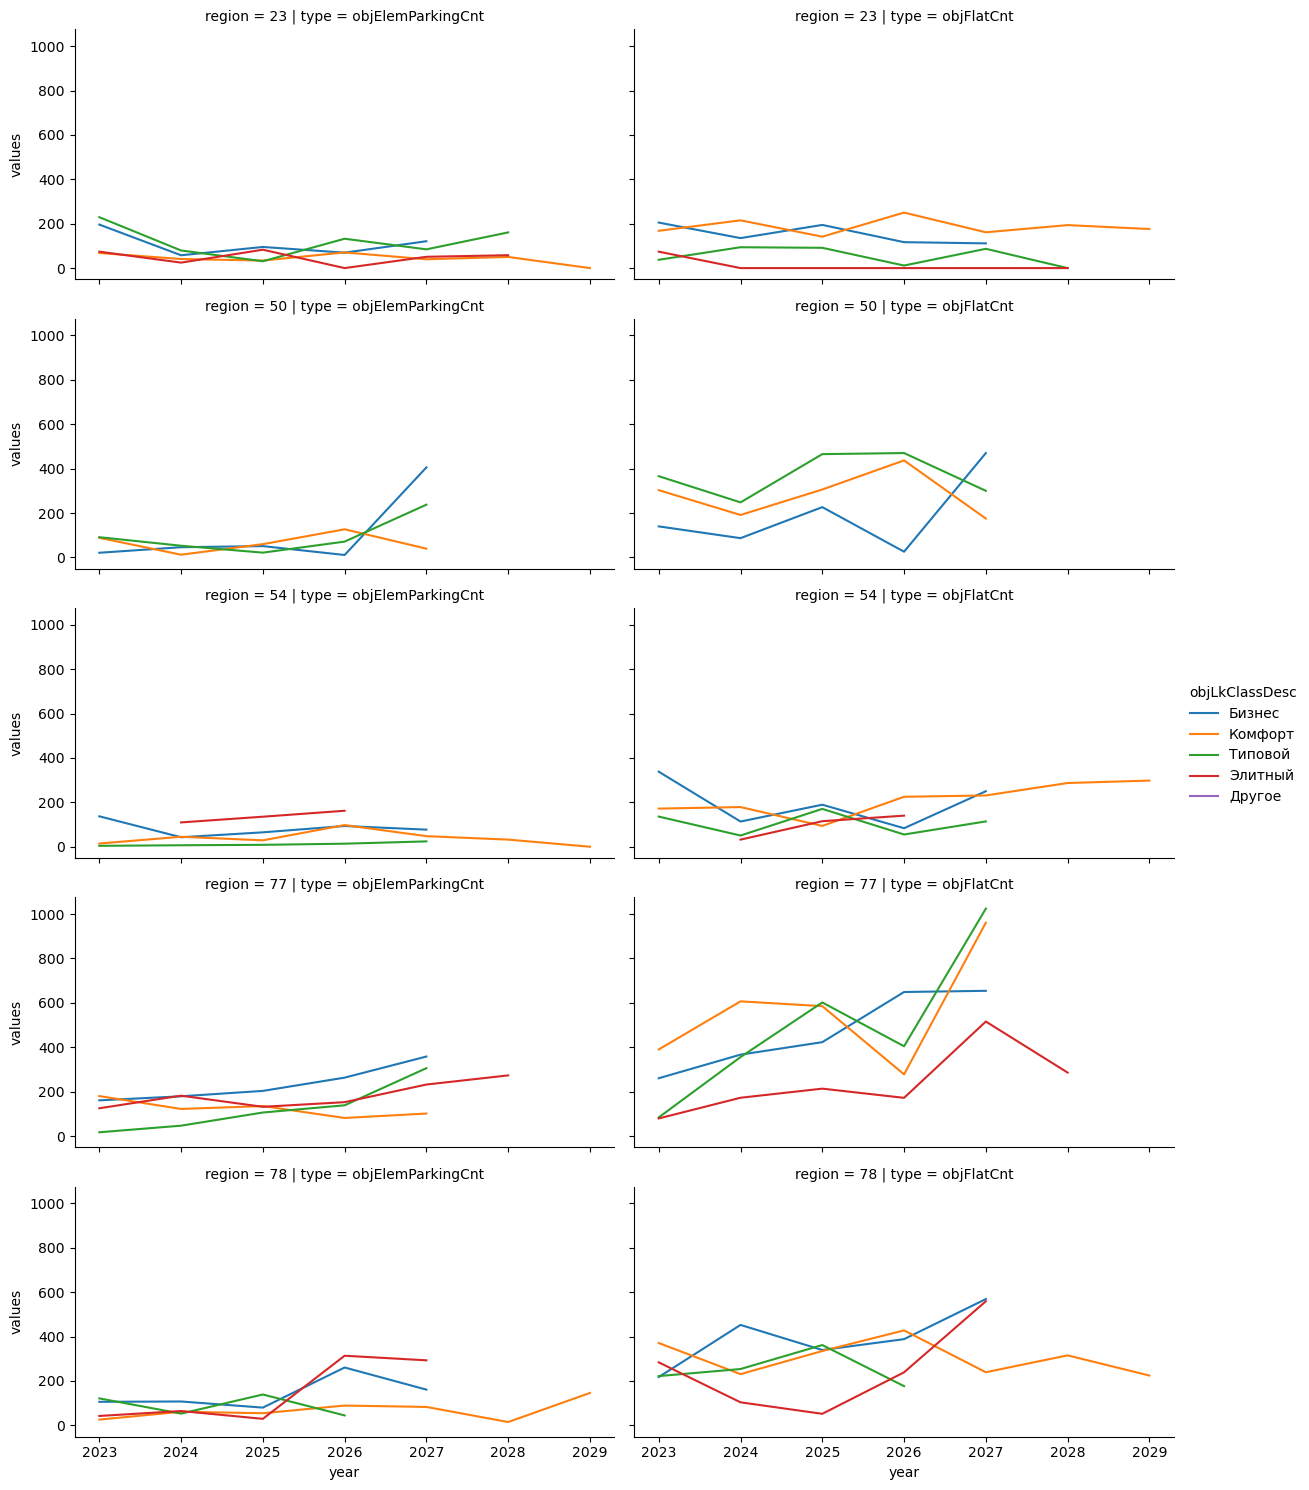

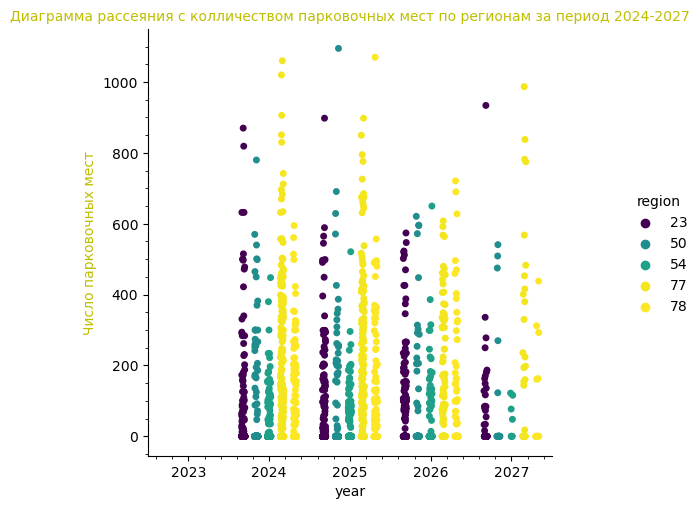

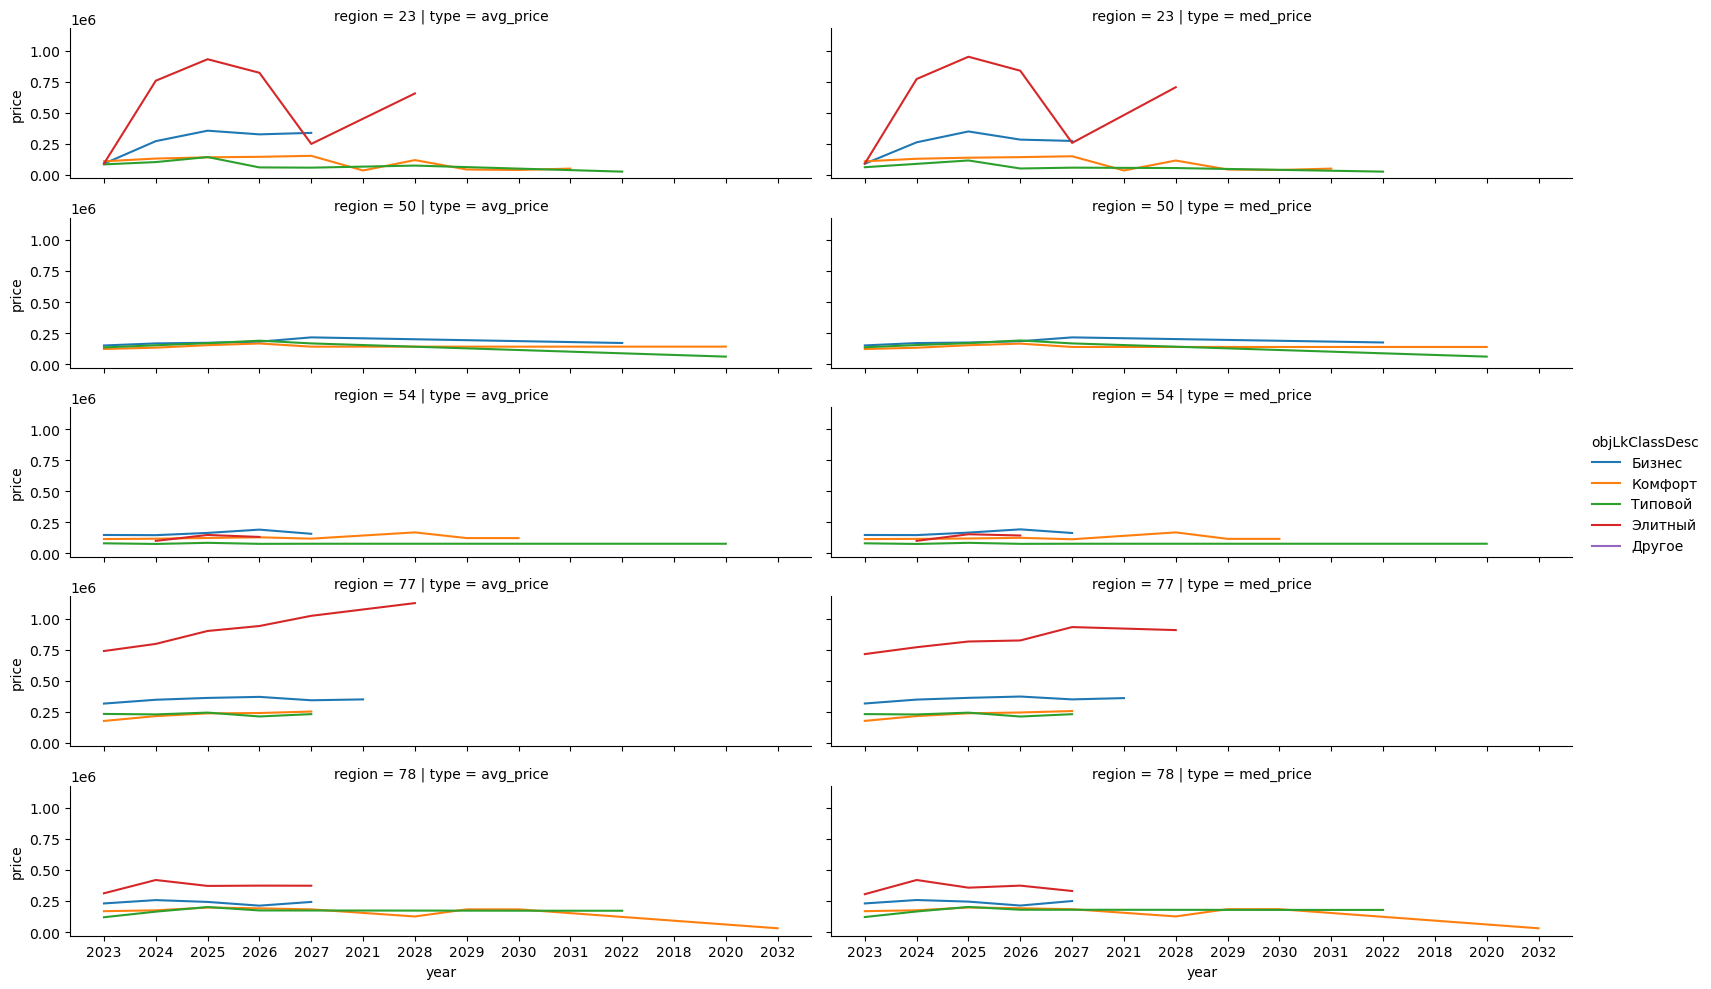

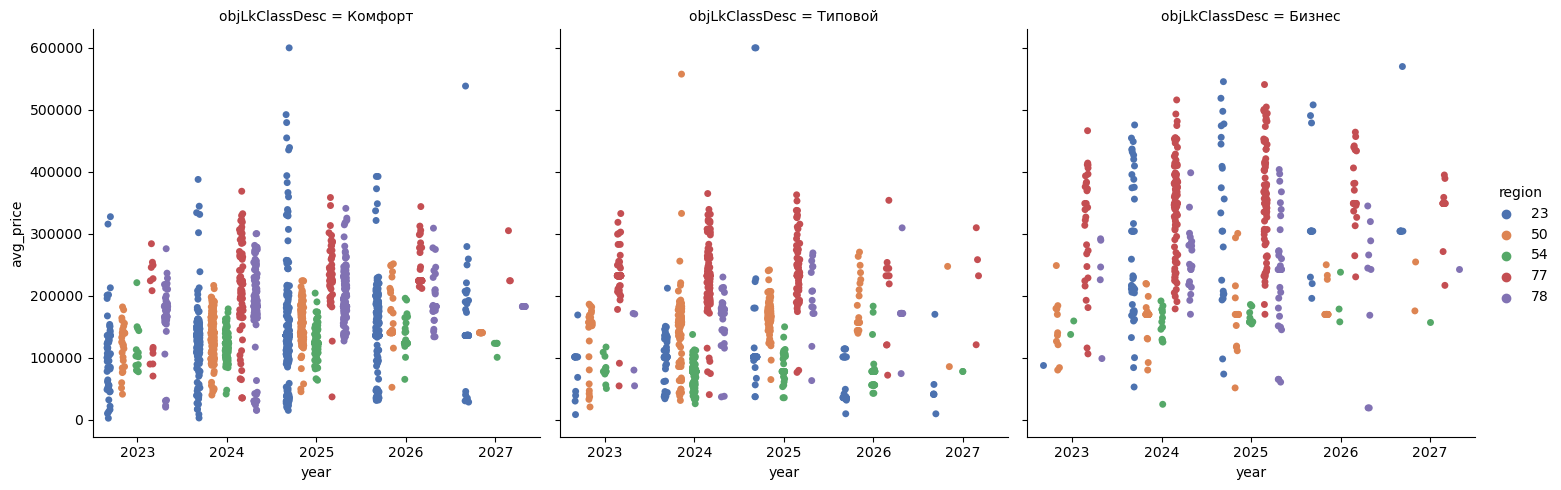

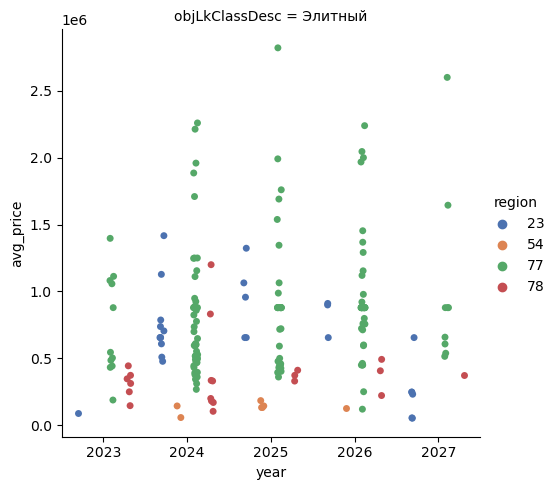

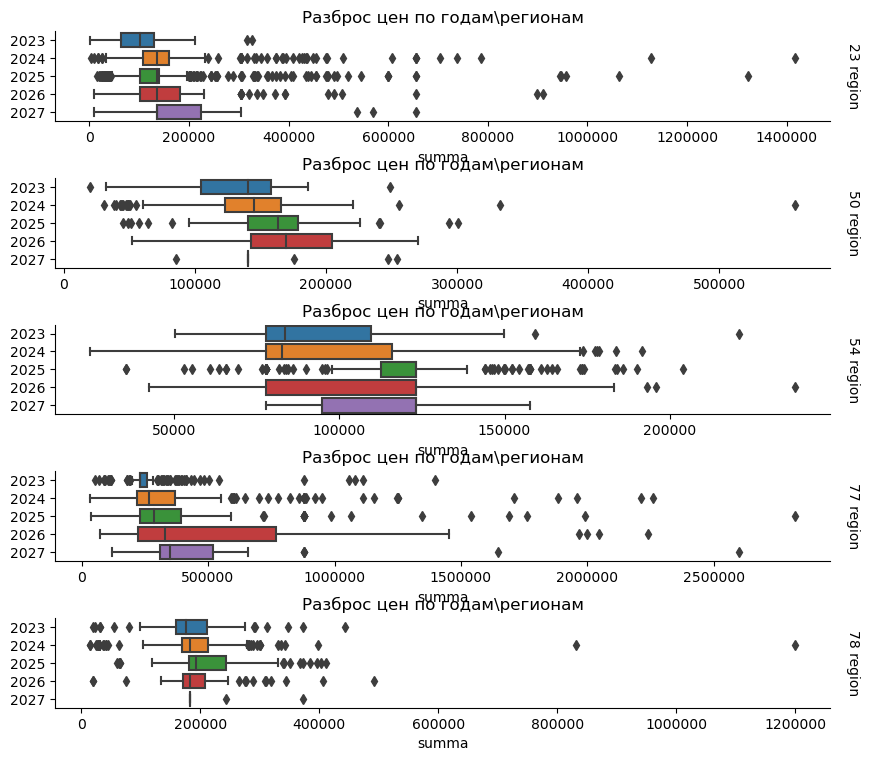

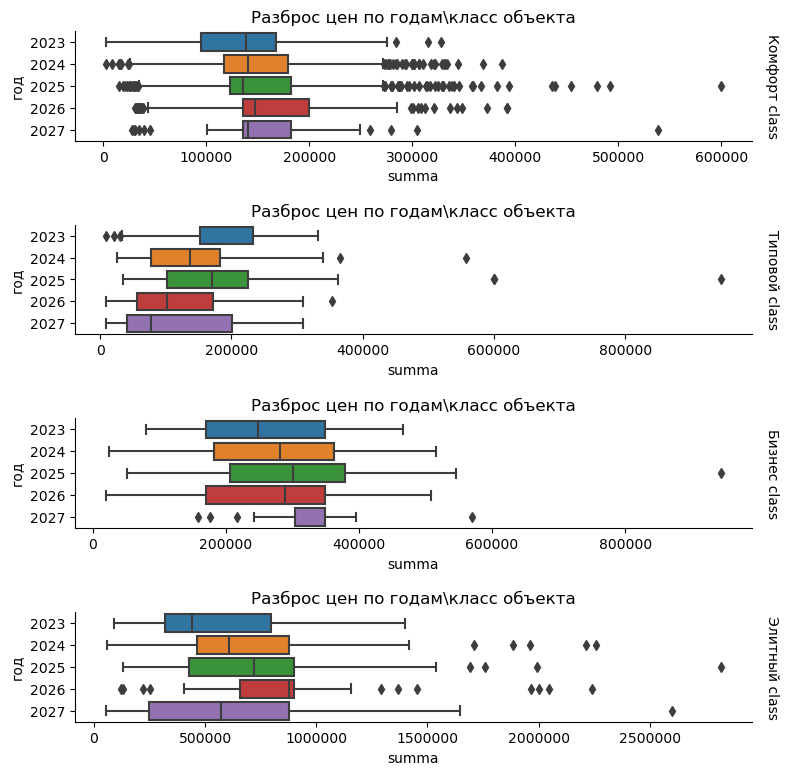

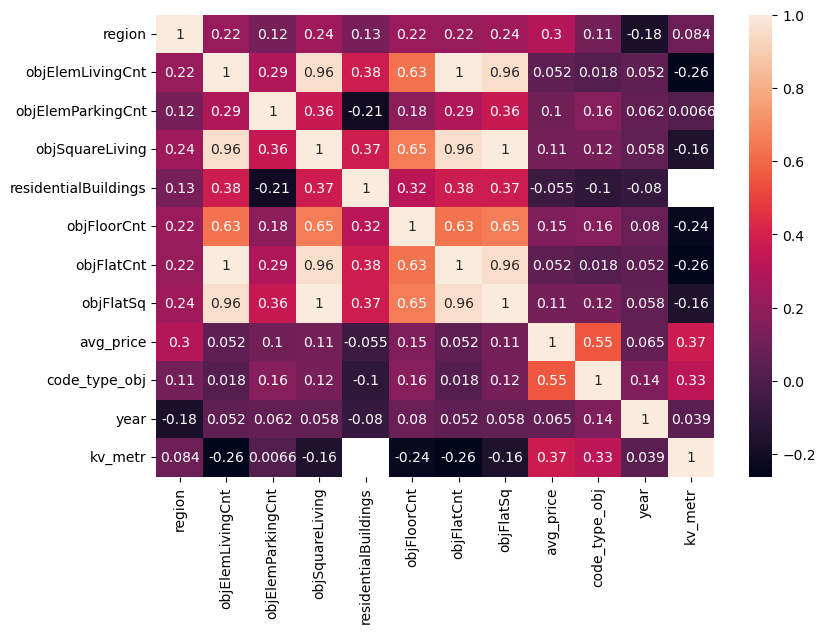

In [614]:
kostili(pd.read_pickle('build.pkl')).run()

